# QML example for fraud detection using EstimatorQNN by Qiskit for synthetic data

#**Installing Qiskit in a previous, running version**

In [ ]:
!pip install qiskit==1.4.3 qiskit-machine-learning==0.8.3 qiskit-algorithms==0.3.1 --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 73.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 17.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.5/310.5 kB 23.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 69.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 MB 13.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.0/109.0 kB 6.3 MB/s eta 0:00:00


In [ ]:
!pip install numpy pandas matplotlib scikit-learn seaborn --quiet

Qiskit version: 1.4.3
Qiskit Machine Learning version: 0.8.3
Qiskit Algorithms version: 0.3.1
ADAM imported successfully: <class 'qiskit_algorithms.optimizers.adam_amsgrad.ADAM'>
Training the quantum model...
Training complete.

Classification Report:

              precision    recall  f1-score   support

           0       0.93      1.00      0.96        13
           1       1.00      0.86      0.92         7

    accuracy                           0.95        20
   macro avg       0.96      0.93      0.94        20
weighted avg       0.95      0.95      0.95        20



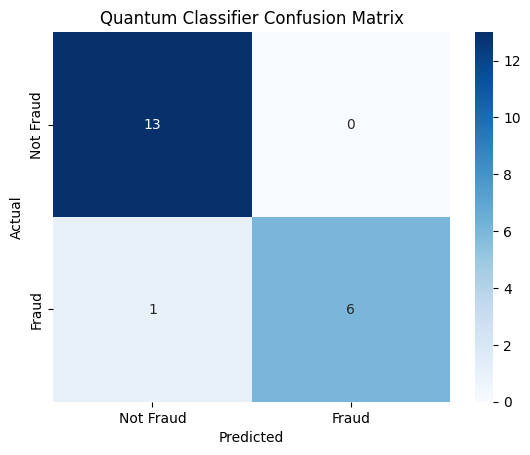

In [ ]:
import qiskit
import qiskit_machine_learning
import qiskit_algorithms
print("Qiskit version:", qiskit.__version__)  # Should be ~1.4.3 for compatibility
print("Qiskit Machine Learning version:", qiskit_machine_learning.__version__)  # Should be ~0.8.3
print("Qiskit Algorithms version:", qiskit_algorithms.__version__)  # Should be '0.3.1'

from qiskit_algorithms.optimizers import ADAM, COBYLA  # ADAM for gradient-based opt; COBYLA alternative
print("ADAM imported successfully:", ADAM)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import make_classification
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

from qiskit.circuit.library import ZZFeatureMap, TwoLocal
from qiskit_machine_learning.algorithms import NeuralNetworkClassifier
from qiskit_machine_learning.neural_networks import EstimatorQNN
from qiskit_machine_learning.gradients import ParamShiftEstimatorGradient  # Explicit gradient to avoid warning
from qiskit.primitives import StatevectorEstimator
from qiskit.quantum_info import SparsePauliOp  # For observables

# Set seed for reproducibility
np.random.seed(42)

# 1. Generate toy binary classification dataset (like fraud / not fraud)
# Keep labels as 0/1 for cross-entropy with multi-output
X, y = make_classification(
    n_samples=100,
    n_features=2,
    n_informative=2,
    n_redundant=0,
    n_clusters_per_class=1,
    random_state=42
)

# 2. Normalize features to [0, π] for angle encoding
scaler = MinMaxScaler(feature_range=(0, np.pi))
X_scaled = scaler.fit_transform(X)

# 3. Split dataset
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

# 4. Define Quantum Circuit Components
num_qubits = 2

# Feature map encodes the input data into quantum states
feature_map = ZZFeatureMap(feature_dimension=num_qubits, reps=1)

# Ansatz (trainable part of the circuit)
ansatz = TwoLocal(num_qubits, rotation_blocks=['ry', 'rz'], entanglement_blocks='cz', reps=1)

# Compose the full circuit
qc = feature_map.compose(ansatz)

# Define observables for binary classification (effective probabilities)
parity = SparsePauliOp("Z" * num_qubits)  # Parity operator
identity = SparsePauliOp("I" * num_qubits)  # Identity
obs0 = (identity + parity) / 2  # Prob class 0 (even parity)
obs1 = (identity - parity) / 2  # Prob class 1 (odd parity)

# Optimizer - Use ADAM for better convergence with gradients
optimizer = ADAM(maxiter=200, lr=0.1)  # Alternative: optimizer = COBYLA(maxiter=200)

# Estimator backend (simulation) - V2 StatevectorEstimator
estimator = StatevectorEstimator()

# Explicit gradient to avoid warning
gradient = ParamShiftEstimatorGradient(estimator=estimator)

# 5. Build the EstimatorQNN with multi-output (shape=(2,)) for probabilities
qnn = EstimatorQNN(
    circuit=qc,
    estimator=estimator,
    gradient=gradient,
    observables=[obs0, obs1],
    input_params=feature_map.parameters,
    weight_params=ansatz.parameters
)

# Build the NeuralNetworkClassifier with cross-entropy
# Fixed initial_point for reproducibility
# Added one_hot=True to use OneHotObjectiveFunction for compatibility with cross_entropy
initial_point = np.random.random(ansatz.num_parameters)  # Seeded random
classifier = NeuralNetworkClassifier(
    neural_network=qnn,
    optimizer=optimizer,
    loss='cross_entropy',  # For classification
    one_hot=True,  # Key fix: Enables one-hot encoding and compatible objective function
    initial_point=initial_point
)

# 6. Train the model
print("Training the quantum model...")
classifier.fit(X_train, y_train)
print("Training complete.")

# 7. Evaluate on test set
y_pred = classifier.predict(X_test)  # Outputs class labels via argmax

print("\nClassification Report:\n")
print(classification_report(y_test, y_pred))

# 8. Optional: Plot confusion matrix
import seaborn as sns

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Not Fraud", "Fraud"], yticklabels=["Not Fraud", "Fraud"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Quantum Classifier Confusion Matrix")
plt.show()

# Next Level: go beyond simple, synthetic data: Analyze the kaggle test dataset for credit card fraud

Dataset loaded successfully. Shape: (284807, 31)
   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.1412

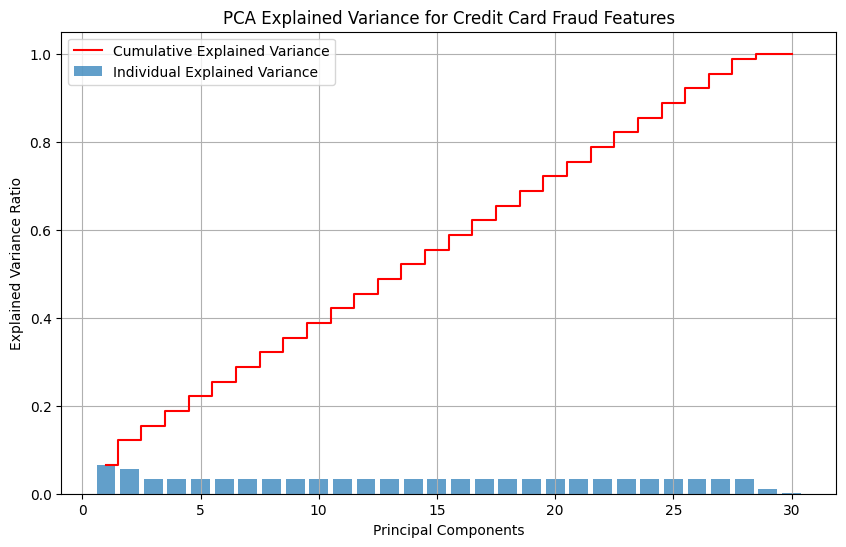


Explained Variance Ratio (first 10 components): [0.06527521 0.05612313 0.03333333 0.03333333 0.03333333 0.03333333
 0.03333333 0.03333333 0.03333333 0.03333333]
Number of components to explain 95% variance: 27


In [ ]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np
import requests
from io import BytesIO
from zipfile import ZipFile

# Step 1: Download and load the zipped dataset from GitHub raw URL
url = 'https://raw.githubusercontent.com/stat432/credit-analysis/main/data-raw/creditcard.csv.zip'
response = requests.get(url)
with ZipFile(BytesIO(response.content)) as z:
    with z.open('creditcard.csv') as f:
        df = pd.read_csv(f)
print("Dataset loaded successfully. Shape:", df.shape)
print(df.head())

# Step 2: Prepare data for PCA (exclude 'Class' as it's the label; 'Time' and 'Amount' are not PCA-transformed in original but included here)
features = df.drop('Class', axis=1)  # Features: Time, V1-V28, Amount

# Standardize the features (important for PCA)
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Step 3: Apply PCA to understand feature criticality (variance explained)
pca = PCA()
pca.fit(features_scaled)

# Explained variance ratio for each principal component
explained_variance = pca.explained_variance_ratio_

# Cumulative explained variance
cumulative_variance = np.cumsum(explained_variance)

# Step 4: Plot explained variance to visualize criticality
plt.figure(figsize=(10, 6))
plt.bar(range(1, len(explained_variance) + 1), explained_variance, alpha=0.7, label='Individual Explained Variance')
plt.step(range(1, len(cumulative_variance) + 1), cumulative_variance, where='mid', label='Cumulative Explained Variance', color='red')
plt.xlabel('Principal Components')
plt.ylabel('Explained Variance Ratio')
plt.title('PCA Explained Variance for Credit Card Fraud Features')
plt.legend()
plt.grid(True)
plt.show()

# Interpretation: Components with higher variance are more "critical" (capture more information)
print("\nExplained Variance Ratio (first 10 components):", explained_variance[:10])
print("Number of components to explain 95% variance:", np.argmax(cumulative_variance >= 0.95) + 1)

In [ ]:
print(cumulative_variance)

[0.06527521 0.12139835 0.15473168 0.18806501 0.22139835 0.25473168
 0.28806501 0.32139835 0.35473168 0.38806501 0.42139835 0.45473168
 0.48806501 0.52139835 0.55473168 0.58806501 0.62139835 0.65473168
 0.68806501 0.72139835 0.75473168 0.78806501 0.82139835 0.85473168
 0.88806501 0.92139835 0.95473168 0.98806501 0.99859484 1.        ]


# Kaggle Credit Card Fraud Data Analysis for the top 5 features of total 30...

**Data source.** Credit Card Fraud Detection dataset. Mirror via Zenodo:  
Liu, L. (2022). *creditcard.csv* [Data set]. Zenodo. https://doi.org/10.5281/zenodo.7395559 — **CC BY 4.0**.  
Original dataset: MLG–ULB, “Credit Card Fraud Detection” (Kaggle).

In [ ]:
import pandas as pd

URL = "https://zenodo.org/records/7395559/files/creditcard.csv?download=1"
df = pd.read_csv(URL, low_memory=False)
print(df.shape)   # expect (284807, 31)
df.head()

(284807, 31)


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


Qiskit version: 1.4.3
Qiskit Machine Learning version: 0.8.3
Qiskit Algorithms version: 0.3.1
ADAM imported successfully: <class 'qiskit_algorithms.optimizers.adam_amsgrad.ADAM'>
Start Time: 2025-08-02 14:57:13
(284807, 31)
Downsampled data shape: (984, 5) (984,)
Training the quantum model...
Training complete: 2025-08-03 00:33:02

Classification Report:

              precision    recall  f1-score   support

           0       0.78      1.00      0.88        98
           1       1.00      0.72      0.84        99

    accuracy                           0.86       197
   macro avg       0.89      0.86      0.86       197
weighted avg       0.89      0.86      0.86       197



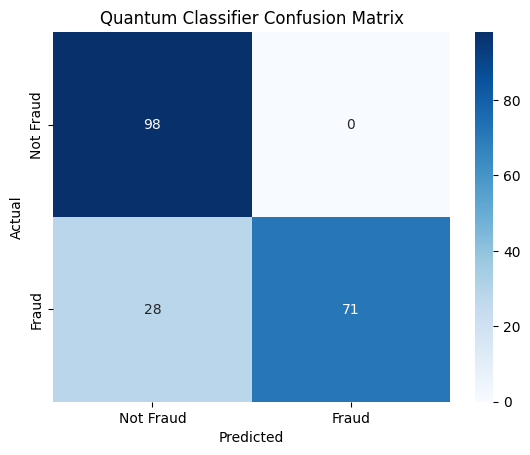

End Time: 2025-08-03 00:33:05


In [ ]:
import qiskit
import qiskit_machine_learning
import qiskit_algorithms
print("Qiskit version:", qiskit.__version__)  # Should be ~1.4.3 for compatibility
print("Qiskit Machine Learning version:", qiskit_machine_learning.__version__)  # Should be ~0.8.3
print("Qiskit Algorithms version:", qiskit_algorithms.__version__)  # Should be '0.3.1'

from qiskit_algorithms.optimizers import ADAM, COBYLA  # ADAM for gradient-based opt; COBYLA alternative
print("ADAM imported successfully:", ADAM)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import make_classification
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

from qiskit.circuit.library import ZZFeatureMap, TwoLocal
from qiskit_machine_learning.algorithms import NeuralNetworkClassifier
from qiskit_machine_learning.neural_networks import EstimatorQNN
from qiskit_machine_learning.gradients import ParamShiftEstimatorGradient  # Explicit gradient to avoid warning
from qiskit.primitives import StatevectorEstimator
from qiskit.quantum_info import SparsePauliOp  # For observables

from datetime import datetime  # For timestamping runs233

# Timestamp to log when the run starts
timestamp = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
print("Start Time:", timestamp)

# Set seed for reproducibility
np.random.seed(42)

# Step 1: Load the dataset directly from public GitHub raw URL (same as Kaggle's creditcard.csv)
URL = "https://zenodo.org/records/7395559/files/creditcard.csv?download=1"
df = pd.read_csv(URL, low_memory=False)
print(df.shape)   # expect (284807, 31)
df.head()

# Step 2: Select the 5 most critical features + label
# Top 5 based on absolute correlation with 'Class': V17 (-0.326), V14 (-0.302), V12 (-0.260), V10 (-0.216), V16 (-0.196)
features_list = ['V17', 'V14', 'V12', 'V10', 'V16']
X = df[features_list].values
y = df['Class'].values  # 0: not fraud, 1: fraud

# Step 3: Downsample for practicality (dataset is imbalanced and large; take all fraud + equal non-fraud)
fraud_indices = np.where(y == 1)[0]
non_fraud_indices = np.random.choice(np.where(y == 0)[0], len(fraud_indices), replace=False)
selected_indices = np.concatenate([fraud_indices, non_fraud_indices])
X = X[selected_indices]
y = y[selected_indices]
print("Downsampled data shape:", X.shape, y.shape)

# Step 4: Normalize features to [0, π] for angle encoding
scaler = MinMaxScaler(feature_range=(0, np.pi))
X_scaled = scaler.fit_transform(X)

# Step 5: Split dataset
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

# Step 6: Define Quantum Circuit Components
num_qubits = len(features_list)  # 5 qubits

# Feature map encodes the input data into quantum states
feature_map = ZZFeatureMap(feature_dimension=num_qubits, reps=1)

# Ansatz (trainable part of the circuit)
ansatz = TwoLocal(num_qubits, rotation_blocks=['ry', 'rz'], entanglement_blocks='cz', reps=2)

# Compose the full circuit
qc = feature_map.compose(ansatz)

# Define observables for binary classification (effective probabilities)
# Measure only qubit 0 in Z (project onto |0> or |1> on that qubit)
z0 = SparsePauliOp('Z' + 'I'*(num_qubits-1))
identity = SparsePauliOp('I'*num_qubits)
obs0 = (identity + z0) / 2  # class 0
obs1 = (identity - z0) / 2  # class 1

# Optimizer - Use ADAM for better convergence with gradients
optimizer = ADAM(maxiter=100, lr=0.1)  # Alternative: optimizer = COBYLA(maxiter=200)

# Estimator backend (simulation) - V2 StatevectorEstimator
estimator = StatevectorEstimator()

# Explicit gradient to avoid warning
gradient = ParamShiftEstimatorGradient(estimator=estimator)

# Step 7: Build the EstimatorQNN with multi-output (shape=(2,)) for probabilities
qnn = EstimatorQNN(
    circuit=qc,
    estimator=estimator,
    gradient=gradient,
    observables=[obs0, obs1],
    input_params=feature_map.parameters,
    weight_params=ansatz.parameters
)

# print a quick message every 10 optimizer steps
step = {"i": 0}
def progress(weights, obj_value):
    step["i"] += 1
    if step["i"] % 10 == 0:
        print(f"[step {step['i']}] loss = {obj_value:.4f}")

# Build the NeuralNetworkClassifier with cross-entropy
# Fixed initial_point for reproducibility
rng = np.random.default_rng(42)
initial_point = rng.random(qnn.num_weights)

classifier = NeuralNetworkClassifier(
    neural_network=qnn,
    optimizer=ADAM(maxiter=50, lr=0.1),
    loss='cross_entropy',
    one_hot=True,
    initial_point=initial_point,
    callback=progress,                     # callback
)

# Step 8: Train the model
print("Training the quantum model...")
classifier.fit(X_train, y_train)

# Timestamp to log when the run starts
timestamp = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
print("Training complete:", timestamp)

# Step 9: Evaluate on test set
y_pred = classifier.predict(X_test)  # Outputs class labels via argmax

print("\nClassification Report:\n")
print(classification_report(y_test, y_pred))

# Step 10: Plot confusion matrix
import seaborn as sns

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Not Fraud", "Fraud"], yticklabels=["Not Fraud", "Fraud"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Quantum Classifier Confusion Matrix")
plt.show()

# Timestamp to log when the run ends
timestamp = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
print("End Time:", timestamp)


In [ ]:
from qiskit.circuit.library import ZZFeatureMap

feature_map = ZZFeatureMap(feature_dimension=3, reps=1)
print(feature_map.decompose())

In [ ]:
from qiskit.circuit.library import TwoLocal

two_local = TwoLocal(3, ['ry', 'rz'], 'cz', 'linear', reps=2, insert_barriers=True)
print(two_local.decompose())

     ┌──────────┐┌──────────┐ ░        ░ ┌──────────┐ ┌──────────┐ ░        ░ »
q_0: ┤ Ry(θ[0]) ├┤ Rz(θ[3]) ├─░──■─────░─┤ Ry(θ[6]) ├─┤ Rz(θ[9]) ├─░──■─────░─»
     ├──────────┤├──────────┤ ░  │     ░ ├──────────┤┌┴──────────┤ ░  │     ░ »
q_1: ┤ Ry(θ[1]) ├┤ Rz(θ[4]) ├─░──■──■──░─┤ Ry(θ[7]) ├┤ Rz(θ[10]) ├─░──■──■──░─»
     ├──────────┤├──────────┤ ░     │  ░ ├──────────┤├───────────┤ ░     │  ░ »
q_2: ┤ Ry(θ[2]) ├┤ Rz(θ[5]) ├─░─────■──░─┤ Ry(θ[8]) ├┤ Rz(θ[11]) ├─░─────■──░─»
     └──────────┘└──────────┘ ░        ░ └──────────┘└───────────┘ ░        ░ »
«     ┌───────────┐┌───────────┐
«q_0: ┤ Ry(θ[12]) ├┤ Rz(θ[15]) ├
«     ├───────────┤├───────────┤
«q_1: ┤ Ry(θ[13]) ├┤ Rz(θ[16]) ├
«     ├───────────┤├───────────┤
«q_2: ┤ Ry(θ[14]) ├┤ Rz(θ[17]) ├
«     └───────────┘└───────────┘
